## H2O AutoML

    https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import h2o
from h2o.automl import H2OAutoML

# Import label encoder
from sklearn import preprocessing

# Import a train/test set into H2O
#from azureml.core import Workspace, Datastore, Dataset

In [2]:
h2o.init(
    nthreads=-1,     # number of threads when launching a new H2O server
    max_mem_size=12  # in gigabytes
)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from C:\Users\SESA475934\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\SESA47~1\AppData\Local\Temp\tmpd8ukxvxm
  JVM stdout: C:\Users\SESA47~1\AppData\Local\Temp\tmpd8ukxvxm\h2o_SESA475934_started_from_python.out
  JVM stderr: C:\Users\SESA47~1\AppData\Local\Temp\tmpd8ukxvxm\h2o_SESA475934_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_SESA475934_wl2909
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,10.66 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [3]:
#h2o.init()

In [4]:
# Import a train/test set into H2O

train = h2o.import_file("C:\\Data_Science\\Competitions\\MachineHack-2021\\train.csv")
test = h2o.import_file("C:\\Data_Science\\Competitions\\MachineHack-2021\\test.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [5]:
train.head(5)

Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type,Sales
FDU32,21.0275,Baking Goods,197.352,OUT046,2004,Small,Tier 2,2689.46
NCT54,21.1024,Meat,148.25,OUT035,1987,Small,Tier 1,3437.35
FDW08,20.8823,Hard Drinks,205.465,OUT035,1999,Small,Tier 3,3129.97
FDJ22,21.0504,Starchy Foods,253.418,OUT046,1996,Small,Tier 1,1306.51
FDF47,21.2479,Baking Goods,240.871,OUT035,1988,Small,Tier 3,1739.77


In [6]:
test.head(5)

Item_ID,Item_W,Item_Type,Item_MRP,Outlet_ID,Outlet_Year,Outlet_Size,Outlet_Location_Type
DRM23,10.1567,Snack Foods,119.319,OUT013,1999,High,Tier 3
FDG47,10.4344,Household,263.6,OUT018,1987,High,Tier 3
FDN21,11.9536,Health and Hygiene,246.287,OUT018,1997,High,Tier 1
FDZ23,14.9485,Dairy,136.201,OUT046,2004,Medium,Tier 2
FDC16,11.08,Canned,173.146,OUT018,2009,Medium,Tier 3


In [7]:
#Convert H2O frame to pandas dataframe(This is done so that data operations can be easily done)

train_as_df = h2o.as_list(train, use_pandas=True)
test_as_df = h2o.as_list(test, use_pandas=True)


Skewness for Item_MRP :  0.055660346208835934


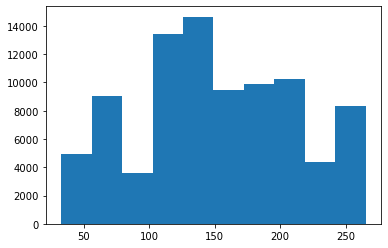


Skewness for Item_W :  -0.17953093828329283


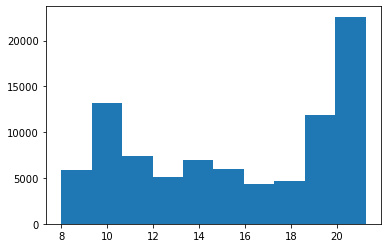

In [8]:
#Drop the ID columns

#train_as_df=train_as_df.drop(['Item_ID','Outlet_ID'], axis = 1)
#test_as_df=test_as_df.drop(['Item_ID','Outlet_ID'], axis = 1)

# Dropping the outlet id column
#train_as_df=train_as_df.drop(['Item_ID'], axis = 1)
#test_as_df=test_as_df.drop(['Item_ID'], axis = 1)


from scipy.stats import skew
from matplotlib import pyplot
from scipy.stats import boxcox
from numpy import exp

data = train_as_df['Item_MRP']
print( '\nSkewness for Item_MRP : ', skew(data))
# histogram
pyplot.hist(data)
pyplot.show()

data = train_as_df['Item_W']
print( '\nSkewness for Item_W : ', skew(data))
# histogram
pyplot.hist(data)
pyplot.show()

In [9]:
# Filter out -ve Sales values

cols = 'Sales'
negative_sales = train_as_df[train_as_df[cols] < 0]
negative_sales
#train = train[train[cols] >= 0] 
train_as_df['Sales'] = train_as_df['Sales'].abs()


Skewness for Sales :  1.1313029228390308


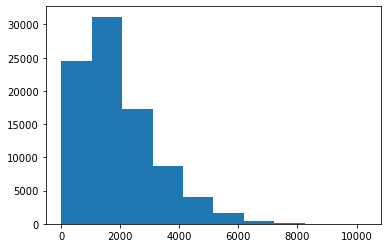

Text(0.5, 0, 'Sample')

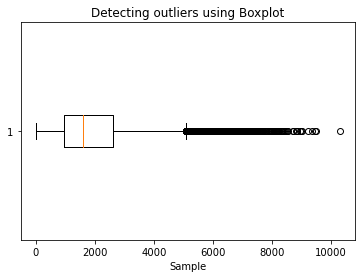

In [10]:
# Outlier Detection in 'Sales'
# After handling outliers in Sales, check the skewness and normality again - it should improve

data = train_as_df['Sales']
print( '\nSkewness for Sales : ', skew(data))
# histogram
pyplot.hist(data)
pyplot.show()

plt.boxplot(data, vert=False)
plt.title("Detecting outliers using Boxplot")
plt.xlabel('Sample')

In [11]:
# Find the outlier datapoints in 'Sales'

# finding the 1st quartile
q1 = np.quantile(train_as_df['Sales'], 0.25)
 
# finding the 3rd quartile
q3 = np.quantile(train_as_df['Sales'], 0.75)
med = np.median(train_as_df['Sales'])
print(med)
 
# finding the iqr region
iqr = q3-q1

print('Median', med)

# finding upper and lower whiskers
upper_bound = q3+(1.5*iqr)
lower_bound = q1-(1.5*iqr)
print(iqr, upper_bound, lower_bound)

outliers = train_as_df[(train_as_df['Sales'] <= lower_bound) | (train_as_df['Sales'] >= upper_bound)].Sales
print('The following are the outliers in the boxplot:{}'.format(outliers))

1606.3078770000002
Median 1606.3078770000002
1648.6986815750004 5081.105758612501 -1513.6889676875005
The following are the outliers in the boxplot:13       6379.790499
30       6741.017116
33       6198.371937
228      5794.834611
246      8699.342857
            ...     
87746    5145.665334
87752    5392.408338
87762    6243.916532
87791    5896.324800
87833    6079.419800
Name: Sales, Length: 2378, dtype: float64


In [12]:
# Handle outliers by replacing values above/below a certain threhold with the threshold
# Winsorization: Percentile based flooring and capping
removeOutlier = '0' # 0 means don't exclude outliers

df=train_as_df
col='Sales'
for col in df:
    #get dtype for column
    dt = df[col].dtype 
    #check if we want to handle outliers?
    if removeOutlier == '1':
        #check if it is a numbers
        if dt == 'int64' or dt == 'float64':
            df[col]=df[col].clip(upper = (df[col].quantile(0.99))) 
            df[col]=df[col].clip(lower = (df[col].quantile(0.01)))

In [13]:
# Create a new field Item_Group based on Item_Type

# create a list of our conditions
conditions = [
    (train_as_df['Item_Type'] == 'Hard Drinks') | (train_as_df['Item_Type'] == 'Soft Drinks'),
    (train_as_df['Item_Type'] == 'Others') | (train_as_df['Item_Type'] == 'Household') | (train_as_df['Item_Type'] == 'Health and Hygiene'),
    (train_as_df['Item_Type'] == 'Baking Goods') | (train_as_df['Item_Type'] == 'Meat') | (train_as_df['Item_Type'] == 'Starchy Foods') | (train_as_df['Item_Type'] == 'Breads') | (train_as_df['Item_Type'] == 'Seafood'),
    (train_as_df['Item_Type'] == 'Fruits and Vegetables') | (train_as_df['Item_Type'] == 'Breakfast') | (train_as_df['Item_Type'] == 'Snack Foods') | (train_as_df['Item_Type'] == 'Frozen Foods') | (train_as_df['Item_Type'] == 'Canned') | (train_as_df['Item_Type'] == 'Dairy')
    ]

# create a list of the values we want to assign for each condition
values = ['Drinks', 'Non_Consummables', 'Food', 'Food']

# create a list of our conditions
conditions_t = [
    (test_as_df['Item_Type'] == 'Hard Drinks') | (test_as_df['Item_Type'] == 'Soft Drinks'),
    (test_as_df['Item_Type'] == 'Others') | (test_as_df['Item_Type'] == 'Household') | (test_as_df['Item_Type'] == 'Health and Hygiene'),
    (test_as_df['Item_Type'] == 'Baking Goods') | (test_as_df['Item_Type'] == 'Meat') | (test_as_df['Item_Type'] == 'Starchy Foods') | (test_as_df['Item_Type'] == 'Breads') | (test_as_df['Item_Type'] == 'Seafood'),
    (test_as_df['Item_Type'] == 'Fruits and Vegetables') | (test_as_df['Item_Type'] == 'Breakfast') | (test_as_df['Item_Type'] == 'Snack Foods') | (test_as_df['Item_Type'] == 'Frozen Foods') | (test_as_df['Item_Type'] == 'Canned') | (test_as_df['Item_Type'] == 'Dairy')
    ]

# create a list of the values we want to assign for each condition
values_t = ['Drinks', 'Non_Consummables', 'Food', 'Food']

In [14]:
train_as_df['Item_Group'] = np.select(conditions, values)
test_as_df['Item_Group'] = np.select(conditions_t, values_t)

In [15]:
#Derive the outlet age column

train_as_df['Outlet_Age'] = 2021 - train_as_df['Outlet_Year']
train_as_df=train_as_df.drop(['Outlet_Year'], axis = 1)

test_as_df['Outlet_Age'] = 2021 - test_as_df['Outlet_Year']
test_as_df=test_as_df.drop(['Outlet_Year'], axis = 1)

In [16]:
#Check for any missing values - train

round((train_as_df.isnull().sum() * 100/ len(train_as_df)),2).sort_values(ascending=False)

Outlet_Age              0.0
Item_Group              0.0
Sales                   0.0
Outlet_Location_Type    0.0
Outlet_Size             0.0
Outlet_ID               0.0
Item_MRP                0.0
Item_Type               0.0
Item_W                  0.0
Item_ID                 0.0
dtype: float64

In [17]:
#Check for any missing values - test

round((test_as_df.isnull().sum() * 100/ len(test_as_df)),2).sort_values(ascending=False)

Outlet_Age              0.0
Item_Group              0.0
Outlet_Location_Type    0.0
Outlet_Size             0.0
Outlet_ID               0.0
Item_MRP                0.0
Item_Type               0.0
Item_W                  0.0
Item_ID                 0.0
dtype: float64

In [18]:
# Break the item id into 2 columns item code and item number

#train['Item_Code'] = [x[:3] for x in train['Item_ID']]
#train['Item_Number'] = train['Item_ID'].str[-2:]
#train = train.drop(['Item_ID'], axis = 1)

#test['Item_Code'] = [x[:3] for x in test['Item_ID']]
#test['Item_Number'] = test['Item_ID'].str[-2:]
#test = test.drop(['Item_ID'], axis = 1)
#
#Convert Item_Number to character and sppend a prefix
#train['Item_Number'] = '__' + train['Item_Number'].astype(str)
#test['Item_Number'] = '__' + test['Item_Number'].astype(str)

In [19]:
# One HOT Encoding

def one_hot_encode(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    original_dataframe = pd.concat([original_dataframe, dummies], axis=1)
    original_dataframe=original_dataframe.drop([feature_to_encode], axis = 1)
    return(original_dataframe)

In [20]:
# Label Encoding

def label_encode(original_dataframe, feature_to_encode):
    # label_encoder object knows how to understand word labels.
    label_encoder = preprocessing.LabelEncoder()    
    # Encode labels in column 'species'.
    original_dataframe[feature_to_encode]= label_encoder.fit_transform(original_dataframe[feature_to_encode])  
    return(original_dataframe)

In [21]:
train_as_df = one_hot_encode(train_as_df, 'Item_Type')
train_as_df = label_encode(train_as_df, 'Outlet_Size')
train_as_df = label_encode(train_as_df, 'Outlet_Location_Type')
train_as_df = one_hot_encode(train_as_df, 'Outlet_ID')
#train_as_df = one_hot_encode(train_as_df, 'Item_Code')
#train_as_df = one_hot_encode(train_as_df, 'Item_Number')
train_as_df = one_hot_encode(train_as_df, 'Item_Group')
train_as_df = one_hot_encode(train_as_df, 'Item_ID')

In [22]:
train_as_df.head(5)

,Item_W,Item_MRP,Outlet_Size,Outlet_Location_Type,Sales,Outlet_Age,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_ID_NCY30,Item_ID_NCY42,Item_ID_NCY53,Item_ID_NCZ17,Item_ID_NCZ18,Item_ID_NCZ29,Item_ID_NCZ41,Item_ID_NCZ42,Item_ID_NCZ53,Item_ID_NCZ54
0,21.027499,197.352319,2,1,2689.457781,17,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21.102371,148.250214,2,0,3437.350375,34,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20.882263,205.465010,2,2,3129.967268,22,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,21.050435,253.417583,2,0,1306.514376,25,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,21.247876,240.871039,2,2,1739.769829,33,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
test_as_df = one_hot_encode(test_as_df, 'Item_Type')
test_as_df = label_encode(test_as_df, 'Outlet_Size')
test_as_df = label_encode(test_as_df, 'Outlet_Location_Type')
test_as_df = one_hot_encode(test_as_df, 'Outlet_ID')
#test_as_df = one_hot_encode(test_as_df, 'Item_Code')
#test_as_df = one_hot_encode(test_as_df, 'Item_Number')
test_as_df = one_hot_encode(test_as_df, 'Item_Group')
test_as_df = one_hot_encode(test_as_df, 'Item_ID')

In [24]:
test_as_df.head(5)

,Item_W,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Age,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,...,Item_ID_NCY30,Item_ID_NCY42,Item_ID_NCY53,Item_ID_NCZ17,Item_ID_NCZ18,Item_ID_NCZ29,Item_ID_NCZ41,Item_ID_NCZ42,Item_ID_NCZ53,Item_ID_NCZ54
0,10.156725,119.319482,0,2,22,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.434425,263.600449,0,2,34,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,11.953589,246.286990,0,0,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14.948546,136.200508,1,1,17,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,11.080042,173.145664,1,2,12,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
#Convert pandas dataframe back to H2O frame
train = h2o.H2OFrame(train_as_df)
test = h2o.H2OFrame(test_as_df) 

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [26]:
# Identify predictors and response
x = train.columns
y = "Sales"
x.remove(y)

In [ ]:
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)

aml = H2OAutoML(max_models=200, seed=1) #max_runtime_secs, max_models
aml.train(x=x, y=y, training_frame=train)  

AutoML progress: |
23:20:00.417: AutoML: XGBoost is not available; skipping it.
23:20:00.444: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
23:20:00.444: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████

In [ ]:
# View the AutoML leaderboard

lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

In [ ]:
# The leader model is stored here

aml.leader

In [ ]:
# To generate predictions on a test set, you can make predictions
# directly on the `"H2OAutoML"` object or on the leader model
# object directly
#preds = aml.predict(test)
# or
preds = aml.leader.predict(test)

In [ ]:
preds.head(5)

In [ ]:
df = test.cbind(preds)
df.head(5)
# Slice cols by vector of names
res = df[:, ["predict"]]
res.head(5)
#Rename column
res.set_names(['Sales']) 

#### Save results

In [ ]:
# Export the file
# There are two ways to save the leader model -- binary format and MOJO format. If you're taking your leader model to production, 
# then we'd suggest the MOJO format since it's optimized for production use.

#h2o.export_file(res, path = "C:\\Data_Science\\Competitions\\MachineHack-2021\\my_submission.csv", force = True)

# Convert to Pandas dataframe
# Save as .CSV file
res_as_df = h2o.as_list(res, use_pandas=True)
res_as_df.to_csv('C:\\Data_Science\\Competitions\\MachineHack-2021\\my_submission.csv', index=False)

In [ ]:
h2o.save_model(aml.leader, path = "C:\\Data_Science\\Competitions\\MachineHack-2021\\h20_model_bin")

In [ ]:
aml.leader.download_mojo(path = "C:\\Data_Science\\Competitions\\MachineHack-2021")

#### Ensemble Exploration

    To understand how the ensemble works, let's take a peek inside the Stacked Ensemble "All Models" model. The "All Models" ensemble is an ensemble of all of the individual models in the AutoML run. This is often the top performing model on the leaderboard.

In [ ]:
# Get model ids for all models in the AutoML Leaderboard
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
# Get the "All Models" Stacked Ensemble model
se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
# Get the Stacked Ensemble metalearner model
metalearner = h2o.get_model(se.metalearner()['name'])

Examine the variable importance of the metalearner (combiner) algorithm in the ensemble. This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM.

In [ ]:
metalearner.coef_norm()

In [ ]:
#We can also plot the base learner contributions to the ensemble.
%matplotlib inline
metalearner.std_coef_plot()